   instant     dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1 2018-01-01       1   0     1        0        6           0   
1        2 2018-01-02       1   0     1        0        0           0   
2        3 2018-01-03       1   0     1        0        1           1   
3        4 2018-01-04       1   0     1        0        2           1   
4        5 2018-01-05       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  days_since_reference  
0   985                     0  
1   801                     

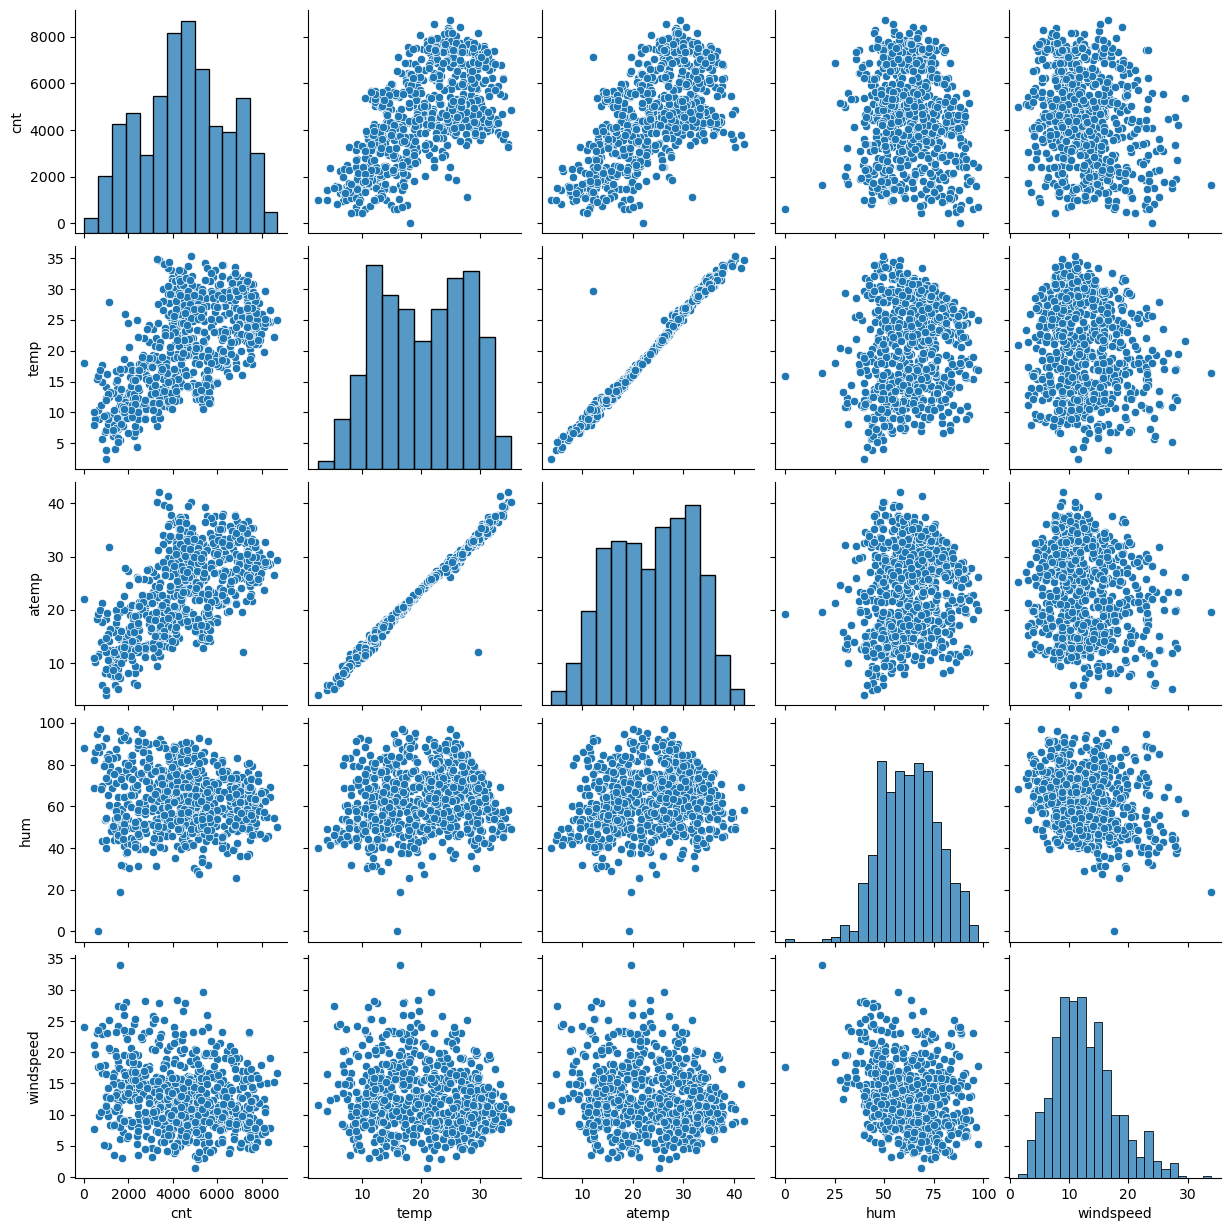

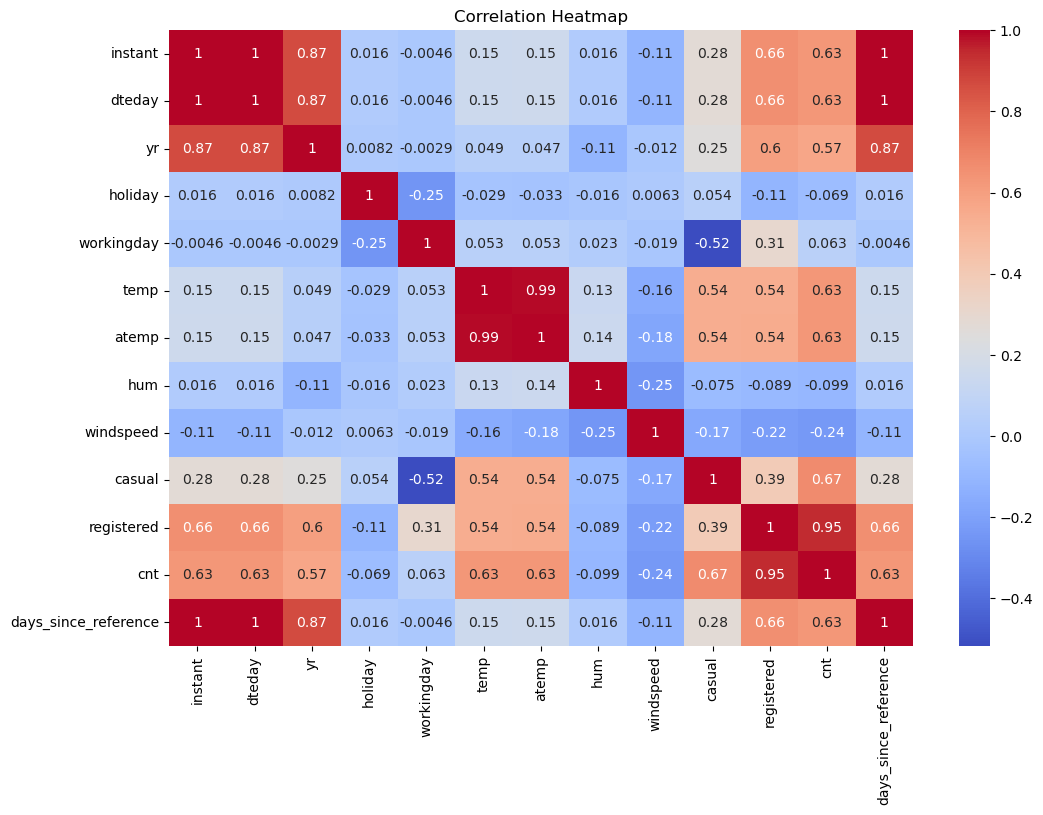

Selected Features: Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'season_Spring',
       'weathersit_Light Rain', 'weekday_Sat', 'weekday_Sun'],
      dtype='object')

Variance Inflation Factor (VIF):
                  Feature        VIF
0                     yr   1.019154
1                holiday        inf
2             workingday        inf
3                   temp  61.429255
4                  atemp  62.333826
5                    hum   1.146492
6          season_Spring   1.671713
7  weathersit_Light Rain   1.104472
8            weekday_Sat        inf
9            weekday_Sun        inf
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     215.5
Date:                Thu, 14 Nov 2024   Prob (F-statistic):          5

E:\New folder\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


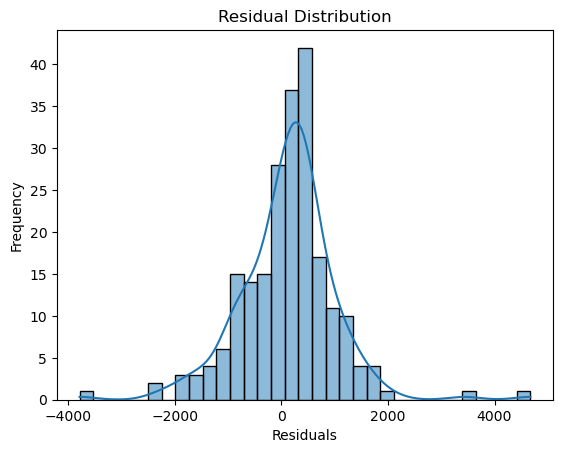

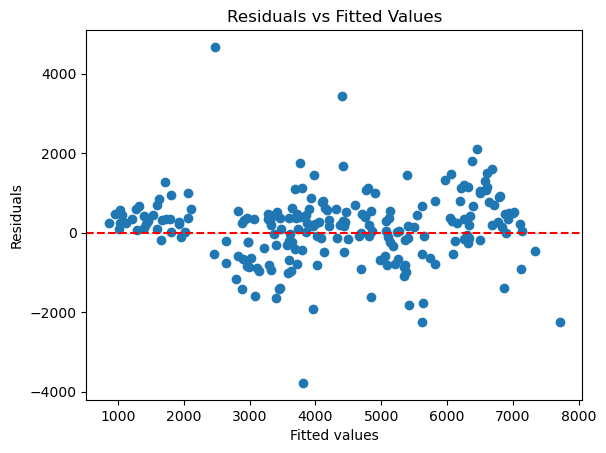

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from datetime import datetime

# Load the dataset
data = pd.read_csv(r"E:/bike_sharing_data.csv")


# Convert 'dteday' to a float representing days since a reference date
reference_date = datetime(2018, 1, 1)
data['dteday'] = pd.to_datetime(data['dteday'], dayfirst=True)
data['days_since_reference'] = (data['dteday'] - reference_date).dt.days

# Initial exploration
print(data.head())
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Assign string values to categorical columns
data['season'] = data['season'].replace({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
data['weathersit'] = data['weathersit'].replace({1: 'Clear', 2: 'Cloudy', 3: 'Light Rain', 4: 'Heavy Rain'})
data['mnth'] = data['mnth'].replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
data['weekday'] = data['weekday'].replace({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 
                                           5: 'Fri', 6: 'Sat'})

# Create dummy variables for categorical features
data = pd.get_dummies(data, columns=['season', 'weathersit', 'mnth', 'weekday'], drop_first=True)

# Ensure all columns are numeric, coercing non-numeric data to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Check for any NaN values after conversion
print(data.isnull().sum())

# Drop rows with NaN values
data.dropna(inplace=True)

# Verify that all remaining columns are numeric
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Column {col} is not numeric.")

# Ensure we only include numeric columns for correlation heatmap
data_numeric = data.select_dtypes(include=[np.number])

# Visualize correlations with pair plot and heatmap
sns.pairplot(data[['cnt', 'temp', 'atemp', 'hum', 'windspeed']])
plt.show()

# Correlation heatmap with dummy variables
plt.figure(figsize=(12, 8))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Drop unnecessary columns (instant, dteday, casual, registered)
data = data.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Splitting the data into features (X) and target variable (y)
X = data.drop('cnt', axis=1)  # Features
y = data['cnt']  # Target variable

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = np.asarray(X)
y = np.asarray(y)

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Feature Selection using Recursive Feature Elimination (RFE)
lin_reg = LinearRegression()
rfe = RFE(lin_reg, n_features_to_select=10)  # Select the top 10 features
rfe = rfe.fit(X, y)

# Select features based on RFE
selected_features = rfe.support_
X = X[:, selected_features]

# Fix for column indexing issue
selected_feature_names = data.drop('cnt', axis=1).columns[selected_features]
print("Selected Features:", selected_feature_names)

# Calculate Variance Inflation Factor (VIF) for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = selected_feature_names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor (VIF):\n", vif_data)

# Final Model Building with selected features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Using statsmodels for detailed summary including Adjusted R-squared
X_train_sm = sm.add_constant(X_train)  # Adding a constant for the intercept
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

# Predicting the demand on the test set
X_test_sm = sm.add_constant(X_test)  # Adding a constant for the intercept in test set
y_pred = model.predict(X_test_sm)

# Model evaluation - Adjusted R-squared and RMSE
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nModel Evaluation Results:")
print("R-squared Score:", r2)
print("Adjusted R-squared Score:", adjusted_r2)
print("Root Mean Squared Error:", rmse)

# Residual Analysis
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter plot to check residuals
plt.scatter(y_pred, residuals)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()